# Skin disease recognition

Dermatology is one of the most neglected areas when it comes to preventing and maintaining human health. Many people do not pay attention to changes that occur on their skin, often treating them as something harmless that they have become accustomed to, putting a visit to a specialist at the bottom of their priority list. These growths, when left untreated, can remain dormant for a long time and then, for example, after exposure to an external factor, can take on a pathological form that significantly threatens our health.

In recent years, due to technological advances, modern computer tools have been increasingly used in the diagnosis of skin diseases. One of these tools is neural networks, which are excellent at detecting patterns in images for classification purposes. This allows for the early detection of potentially dangerous skin changes and faster medical intervention. The development of technology in image recognition enables the creation of increasingly advanced systems that can help diagnose skin diseases and improve the health of patients. This paper presents the process of recognizing skin changes based on photographs and evaluates the effectiveness of machine learning algorithms in this task.

Data comes from:
*Tschandl P., Rosendahl C. & Kittler H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018)*

<img src="img/dermatolog.jpg" alt="Dermatologist" width="700">

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data gathering

### Dataset description
The dataset consists of following columns:
 - *lesion_id* - id number of particular lesion
 - *image_id* - image file name
 - *dx* - recognized lesion code, which stands for:
    - *akiec* - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    - *bcc* - basal cell carcinoma
    - *bkl* - benign keratosis-like lesions
    - *df* - dermatofibroma
    - *mel* - melanoma
    - *nv* - melanocytic nevi
    - *vasc* - vascular lesions

 - *dx_type* - defines how was the lesion was recognized:
    - *histo* - through histopathology
    - *follow-up* - follow-up examination
    - *consensus* - expert consensus
    - *confocal* - confirmation by in-vivo confocal microscopy
 - *age* - patient's age group
 - *sex* - patient's sex
 - *localization* - localization of the lesion


### Loading images metadata

In [2]:
# Read the file with recognized lesions data
lesions_df = pd.read_csv('archive/HAM10000_metadata.csv')
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Loading images
I will load the images using data generator object. A data generator is an object in TensorFlow that enables easy loading of large datasets, such as images, into memory one batch at a time. In the case of large datasets, such as image datasets, loading them all at once into memory can lead to the exhaustion of memory resources, as well as prolong the time it takes to load the data.

To properly connect labels from the dataframe with photos we need to pass correct filename, which mean we must modify the *image_id* column:

In [3]:
lesions_df['image_id'] = lesions_df['image_id'] + '.jpg'
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear


For proper training/validation data split I will shuffle the dataset, so that all classes are more-less evenly distributed in those subsets.

In [4]:
lesions_df = lesions_df.sample(frac=1)

Now I can create the generator:

In [61]:
# Creating ImageDataGenerator object
img_generator = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=180
                                   )

### Splitting the data into training, validation and test sets

In [60]:
# First data split
lesions_train_df, lesions_test_df = train_test_split(lesions_df, test_size=0.1)
# Second split
lesions_train_df, lesions_valid_df = train_test_split(lesions_train_df, test_size=0.2)
print(f'Training data: {len(lesions_train_df)} elements')
print(f'Validation data: {len(lesions_valid_df)} elements')
print(f'Testing data: {len(lesions_test_df)} elements')

Training data: 7210 elements
Validation data: 1803 elements
Testing data: 1002 elements


Now create generators

In [62]:
# Images directory
img_dir = 'archive/HAM10000_images'
# Training data generator
train_generator = img_generator.flow_from_dataframe(dataframe=lesions_train_df,  # DataFrame with labels
                                                    directory=img_dir,  # images directory
                                                    x_col='image_id',  # column name containing images names
                                                    y_col='dx',  # column name containing labels
                                                    class_mode='categorical',  # classification mode
                                                    batch_size=32)
# Validation data generator
validation_generator = img_generator.flow_from_dataframe(dataframe=lesions_valid_df,
                                                         directory=img_dir,
                                                         x_col='image_id',
                                                         y_col='dx',
                                                         class_mode='categorical',
                                                         batch_size=32)
# Testing data generator
test_generator = img_generator.flow_from_dataframe(dataframe=lesions_test_df,
                                                    directory=img_dir,
                                                    x_col='image_id',
                                                    y_col='dx',
                                                    class_mode='categorical',
                                                    batch_size=32)

Found 7210 validated image filenames belonging to 7 classes.
Found 1803 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


### Check how the data has been split
We have to check if the data has been spit evenly into both - training and testing - sets.

In [65]:
# Counts values
index_train, counts_train = np.unique(train_generator.classes, return_counts=True)
index_valid, counts_valid = np.unique(validation_generator.classes, return_counts=True)
index_test, counts_test = np.unique(test_generator.classes, return_counts=True)
# Create DataFrame
split_counts_df = pd.DataFrame(index=train_generator.class_indices.keys())
split_counts_df['Training'] = counts_train
split_counts_df['Validation'] = counts_valid
split_counts_df['Testing'] = counts_test
# Show the DataFrame
split_counts_df

,Training,Validation,Testing
akiec,242,53,32
bcc,365,85,64
bkl,800,200,99
df,83,19,13
mel,801,207,105
nv,4813,1216,676
vasc,106,23,13


Now let's show it on the plot

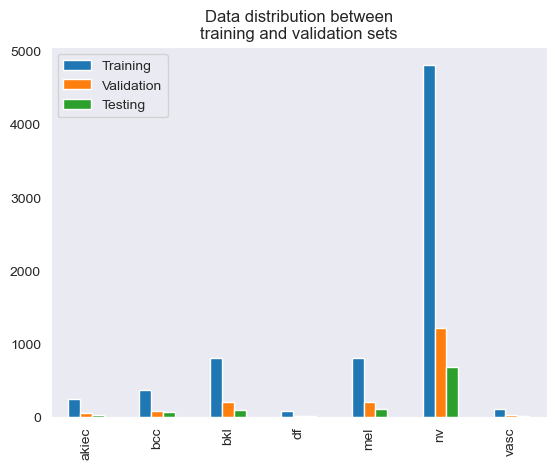

In [66]:
ax = split_counts_df.plot.bar()
ax.grid(False)
ax.set_title('Data distribution between\ntraining and validation sets')

plt.show()

**Conclusion:** The data has been split evenly, so in both datasets there will be similar samples distribution.

# Exploratory data analysis
Let's have a look at how the diseases are distributed

### Lession types count
Let's check how many lesions of each category are in the dataset. I will split it into two charts, where one will show distribution of distinct lesions shown in the dataset and the other will show distribution of lesions images, because some lesions have couple photos. To do it I will prepare the second dataset for them.

In [6]:
distinct_lesions_df = lesions_df.drop('image_id', axis=1).drop_duplicates()
distinct_lesions_df.head()

,lesion_id,dx,dx_type,age,sex,localization
5931,HAM_0002570,nv,follow_up,30.0,male,trunk
4814,HAM_0004797,nv,follow_up,50.0,female,back
294,HAM_0003800,bkl,histo,70.0,male,upper extremity
2648,HAM_0003216,bcc,histo,85.0,female,face
5666,HAM_0006276,nv,follow_up,45.0,male,back


Next I will prepare a DataFrame to store both counted values

In [24]:
counts_df = pd.DataFrame()
counts_df['images_count'] = lesions_df['dx'].value_counts()
counts_df['lesions_count'] = distinct_lesions_df['dx'].value_counts()
counts_df

,images_count,lesions_count
nv,6705,5403
mel,1113,616
bkl,1099,727
bcc,514,327
akiec,327,228
vasc,142,98
df,115,73


...and create a plot

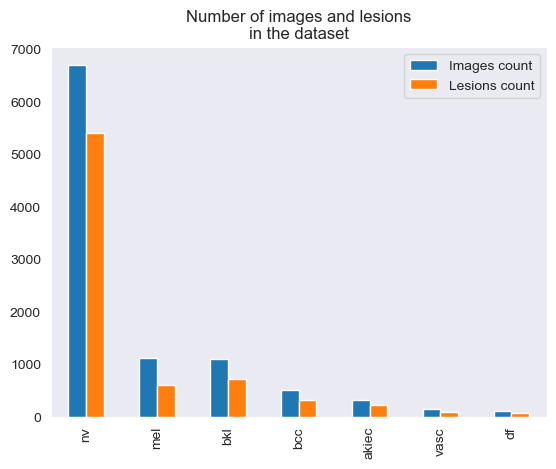

In [29]:
ax = counts_df.plot.bar()
ax.legend(labels=['Images count', 'Lesions count'])
ax.set_title('Number of images and lesions\nin the dataset')
ax.grid(False)
plt.show()

### TODO
 - density plot for each lesion type vs age

# Building model

### Model architecture
TODO: describe model architecture

In [13]:
model = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(128, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dense(7, activation='softmax')
])

### Model compilation
Model compilation is responsible for configuring it for training by specifying the optimizer, loss function, and metrics to be used during the training process. The optimizer determines how the model is updated based on the loss function and gradients calculated during training, while the loss function is used to measure the error between the predicted output and the actual output. Metrics are used to evaluate the performance of the model during training and can be used to monitor the progress of the training process.

TODO: choose parameters for non-even data distribution as 'accuracy' is good for evenly distributed classes
TODO: apply class weight distribution

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

### Training the model

In [15]:
# trained_model = model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=validation_generator
# )

# Feature engineering

# Pytania

 - czy dzielić dane na treningowe, walidacyjne i testowe, czy wystarczą treningowe i walidacyjne?
 - co można jeszcze uwzględnić w EDA?
 - w jaki sposób polepszyć dokładność modelu?
